# 0. Imports

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import sys 
sys.path.append("..")
from src.analysis_support import error_band


# 1. Load datasets

## 1.1 Flights

In [95]:
flight_itinieraries = pd.read_csv("../data/flights/flight_itinieraries_cleaned.csv",index_col=0)

## 1.2 Accommodations

In [96]:
accommodations_df = pd.read_csv("../data/accommodations/acommodations_cleaned.csv",index_col=0)

## 1.3 Activities

In [124]:
activities_df = pd.read_csv("../data/activities/civitatis_activities_cleaned.csv", index_col=0)

# 2. Analysis of destinations

### 2.1 Flights

In [22]:
flight_itinieraries.columns

Index(['score', 'price', 'price_currency', 'duration_departure',
       'duration_return', 'stops_departure', 'stops_return',
       'departure_departure', 'arrival_departure', 'departure_return',
       'arrival_return', 'company_departure', 'company_return',
       'self_transfer', 'fare_isChangeAllowed', 'fare_isPartiallyChangeable',
       'fare_isCancellationAllowed', 'fare_isPartiallyRefundable',
       'origin_airport_departure', 'destination_airport_departure',
       'origin_airport_return', 'destination_airport_return', 'week',
       'destination_city'],
      dtype='object')

In [80]:
flight_itinieraries["self_transfer_int"] = flight_itinieraries["self_transfer"].astype(int)

Number of flights from every city for all 3 weeks:

In [20]:
flight_itinieraries[["destination_city","origin_airport_departure"]].value_counts().reset_index()

,destination_city,origin_airport_departure,count
0,New,Madrid,3031
1,Paris,Madrid,1382
2,Rome,Madrid,1327
3,Berlin,Madrid,1120
4,Madeira,Madrid,642
5,Phuket,Madrid,468
6,Havana,Madrid,174


In [90]:
flight_itinieraries.pivot_table(
    index='destination_city',
    columns='week',
    values='price', 
    aggfunc='count',
    fill_value=0 
).T

destination_city,Berlin,Havana,Madeira,New,Paris,Phuket,Rome
week,,,,,,,
1,394,66,315,1001,407,156,654
2,392,50,147,1108,461,140,250
3,334,58,180,922,514,172,423


Average flight duration:

In [83]:
flight_itinieraries.groupby("destination_city")[["duration_departure"]].mean().sort_values(by="duration_departure")/60

,duration_departure
destination_city,
Rome,3.826174
Paris,4.253437
Berlin,5.255804
Madeira,12.420950
New,13.121621
Phuket,20.777244
Havana,21.866667


Average flight cost:

In [82]:
flight_itinieraries.groupby("destination_city")[["price"]].mean().sort_values(by="price")

,price
destination_city,
Rome,306.046722
Berlin,344.746429
Paris,370.965268
Madeira,572.485981
New,687.348400
Havana,1379.528736
Phuket,1842.010684


Cheapest flight:

In [76]:
cheapest_flight_durations = (
    flight_itinieraries.groupby('destination_city')
        .apply(lambda x: pd.DataFrame({
        'smallest_price_EUR': [x.nsmallest(1, 'price')['price'].mean()],
        'duration_hours': [x.nsmallest(1, 'price')['duration_departure'].mean()/60],
        'stops': [x.nsmallest(1, 'price')['stops_departure'].mean()]
    }))
    .reset_index(level=1,drop=True)
    .sort_values(by="smallest_price_EUR",ascending=True)
)

cheapest_flight_durations

C:\Users\Miguel\AppData\Local\Temp\ipykernel_6380\2098632902.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.DataFrame({


,smallest_price_EUR,duration_hours,stops
destination_city,,,
Paris,71.0,2.166667,0.0
Rome,84.0,2.416667,0.0
Madeira,120.0,8.833333,1.0
Berlin,131.0,3.083333,0.0
New,382.0,13.250000,1.0
Phuket,610.0,22.166667,1.0
Havana,673.0,16.666667,2.0


Average flight cost by top_10 cheapest:

In [57]:
mean_smallest_prices_durations = (
    flight_itinieraries.groupby("destination_city")
    .apply(lambda x: pd.DataFrame({
        'mean_smallest_price_EUR': [x.nsmallest(10, 'price')['price'].mean()],
        'mean_smallest_duration_hours': [x.nsmallest(10, 'price')['duration_departure'].mean()/60]
    }))
    .reset_index(level=1,drop=True)
    .sort_values(by="mean_smallest_price_EUR")
)
mean_smallest_prices_durations

C:\Users\Miguel\AppData\Local\Temp\ipykernel_6380\3229344513.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.DataFrame({


,mean_smallest_price_EUR,mean_smallest_duration_hours
destination_city,,
Rome,91.6,2.458333
Paris,103.3,2.175000
Berlin,148.2,4.791667
Madeira,168.6,10.858333
New,386.7,18.050000
Havana,741.2,15.875000
Phuket,778.4,23.366667


Average flight cost by top_10 scores:

In [81]:
mean_largest_score_prices_durations = (
    flight_itinieraries.groupby("destination_city")
    .apply(lambda x: pd.DataFrame({
        'mean_price_EUR': [x.nlargest(10, 'score')['price'].mean()],
        'mean_duration_hours': [x.nlargest(10, 'score')['duration_departure'].mean()/60],
        'mean_stops': [x.nlargest(10, 'score')['stops_departure'].mean()],
        "mean_self_transfer": [x.nlargest(10, 'score')['self_transfer'].mean()],
    }))
    .reset_index(level=1,drop=True)
    .sort_values(by="mean_price_EUR")
)
mean_largest_score_prices_durations

C:\Users\Miguel\AppData\Local\Temp\ipykernel_6380\2042801280.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.DataFrame({


,mean_price_EUR,mean_duration_hours,mean_stops,mean_self_transfer
destination_city,,,,
Rome,112.8,2.433333,0.0,0.0
Paris,185.6,2.158333,0.0,0.0
Berlin,248.8,3.400000,0.2,0.1
Madeira,262.0,5.450000,1.0,0.3
New,494.8,8.691667,0.0,0.0
Phuket,943.1,20.541667,1.1,0.0
Havana,1016.5,15.300000,1.0,0.0


Average price per week, for top 10 scores per destination

In [91]:
average_price_top_10_scores_per_week = (
    flight_itinieraries.groupby('week')
    .apply(lambda x: x.nlargest(10, 'score')['price'].mean())
    .reset_index(name='average_price_top_10_scores')
)
average_price_top_10_scores_per_week

C:\Users\Miguel\AppData\Local\Temp\ipykernel_6380\1210879034.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, 'score')['price'].mean())


,week,average_price_top_10_scores
0,1,497.0
1,2,372.8
2,3,277.8


In [93]:
average_price_top_10_scores_per_dest_week = (
    flight_itinieraries.groupby(['week', 'destination_city'])
    .apply(lambda x: x.nlargest(10, 'score')['price'].mean())
    .reset_index(name='average_price_top_10_scores')
)
average_price_top_10_scores_per_dest_week.pivot(
    index='destination_city', 
    columns='week', 
    values='average_price_top_10_scores'
).fillna(0) 

C:\Users\Miguel\AppData\Local\Temp\ipykernel_6380\2056908848.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, 'score')['price'].mean())


week,1,2,3
destination_city,,,
Berlin,298.6,238.8,212.4
Havana,1179.1,1039.4,751.8
Madeira,336.8,246.1,217.4
New,509.0,504.9,495.6
Paris,263.3,249.5,110.7
Phuket,1057.0,1072.3,1069.6
Rome,167.2,119.4,96.6


### 2.2 Accommodations

In [100]:
accommodations_df.columns

Index(['name', 'url', 'price_currency', 'total_price_amount',
       'distance_city_center_km', 'score', 'n_comments', 'close_to_metro',
       'sustainability_cert', 'room_type', 'double_bed', 'single_bed',
       'free_cancellation', 'breakfast_included', 'pay_at_hotel',
       'location_score', 'free_taxi', 'week', 'type', 'destination'],
      dtype='object')

In [110]:
accommodations_df["sustainability_cert_int"] = accommodations_df["sustainability_cert"].str.replace("Yes","1").str.replace("No","0").astype(int)

Score by top 10 cheapest acommodations per key destination

C:\Users\Miguel\AppData\Local\Temp\ipykernel_6380\1519910352.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.DataFrame({
C:\Users\Miguel\AppData\Local\Temp\ipykernel_6380\1519910352.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(mean_smallest_prices.index, rotation=45, ha='right')


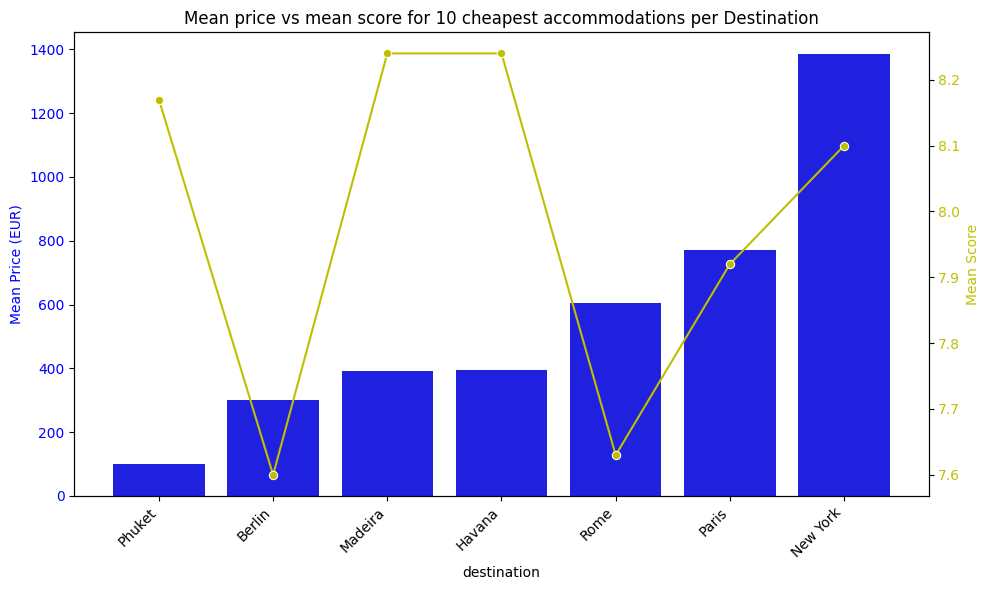

In [122]:
mean_smallest_prices = (
    accommodations_df.groupby("destination")
    .apply(lambda x: pd.DataFrame({
        'mean_price_EUR': [x.nsmallest(10, 'total_price_amount')['total_price_amount'].mean()],
        'mean_score': [x.nsmallest(10, 'total_price_amount')['score'].mean()],
        'mean_centre_distance': [x.nsmallest(10, 'total_price_amount')['distance_city_center_km'].mean()]
    }))
    .reset_index(level=1,drop=True)
    .sort_values(by="mean_price_EUR")
)

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x='destination', y='mean_price_EUR', data=mean_smallest_prices, ax=ax1, color='b')
ax1.set_ylabel('Mean Price (EUR)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
sns.lineplot(x='destination', y='mean_score', data=mean_smallest_prices, ax=ax2, color='y', marker="o")
ax2.set_ylabel('Mean Score', color='y')
ax2.tick_params(axis='y', labelcolor='y')

ax1.set_xticklabels(mean_smallest_prices.index, rotation=45, ha='right')

plt.title('Mean price vs mean score for 10 cheapest accommodations per Destination')
plt.tight_layout()

plt.show()


Weekly evolution of accommodation price per destination

In [108]:
average_price_top_10_scores_per_dest_week = (
    accommodations_df.groupby(['week', 'destination'])
    .apply(lambda x: x.nlargest(10, 'score')['total_price_amount'].mean())
    .reset_index(name='average_price_top_10_scores')
)
average_price_top_10_scores_per_dest_week.pivot(
    index='destination', 
    columns='week', 
    values='average_price_top_10_scores'
).fillna(0) 

C:\Users\Miguel\AppData\Local\Temp\ipykernel_6380\4001283234.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, 'score')['total_price_amount'].mean())


week,1,2,3
destination,,,
Berlin,1191.0,1160.4,1160.2
Havana,1176.7,1189.5,1142.2
Madeira,1017.3,1045.9,1046.2
New York,0.0,0.0,1384.0
Paris,1161.9,1112.0,1246.6
Phuket,752.1,680.7,760.6
Rome,1161.1,1168.2,1204.5


Sustainability certification % by destination

In [112]:
accommodations_df.groupby("destination")["sustainability_cert_int"].mean().reset_index()

,destination,sustainability_cert_int
0,Berlin,0.310526
1,Havana,0.000000
2,Madeira,0.042787
3,New York,0.000000
4,Paris,0.005310
5,Phuket,0.000000
6,Rome,0.001813


### 2.3 Activities

In [125]:
activities_df.columns

Index(['Unnamed: 0', 'activity_name', 'description', 'url', 'image',
       'available_days', 'available_times', 'latitude', 'longitude', 'address',
       'price', 'currency', 'category', 'week', 'destination', 'hours_min',
       'hours_max'],
      dtype='object')

Top category per destination

In [140]:
(activities_df.groupby('destination')['category']
    .agg(lambda x: x.value_counts().index[2] if len(x.value_counts()) > 1 else np.nan)
    .reset_index(name='second_top_category'))

,destination,second_top_category
0,berlin,Inglés
1,madeira,Paseos en barco
2,nueva-york,Espectáculos
3,paris,Inglés
4,phuket,"Seguro, sin contratiempos"
5,roma,Espectáculos


Average and median price per activity

In [133]:
(activities_df.groupby('destination')['price'].agg(["mean","median"]))

,mean,median
destination,,
berlin,10.556497,6.600
madeira,11.314254,10.000
nueva-york,25.457199,13.750
paris,12.635709,6.000
phuket,819.464444,382.320
roma,21.830811,11.225


Mean and median price per activity in Phuket are bigger than in other destinations, that's probably because activities in Phuket are longer or more adventurous, like long trips in boat or.

In [134]:
(activities_df.groupby('destination')['hours_max'].agg(["mean","median"]))

,mean,median
destination,,
berlin,12.378521,4.000000
madeira,7.626812,4.000000
nueva-york,12.272926,2.583333
paris,7.649560,2.000000
phuket,22.592593,8.000000
roma,29.277369,3.000000


In most cases, very expensive activities inflate the mean activity price.